# Diffusion-Reaction Equation With Nernst Convection Term

\begin{align}
    -\alpha \rho_+^{n+1, k+1} + \qty{1+2\alpha}\rho^{n+2,k+1}_+ - \alpha \rho^{n+1, k-1}_+ &= \rho^{n,k}_+ - \alpha\rho_+^{n+1,k}\qty{\Psi^{n+1,k+1}-2\Psi^{n+1,k}+ \Psi^{n+1,k-1}} - \alpha \qty{\rho^{n+1,k+1}-\rho^{n+1,k}}\qty{\Psi^{n+1,k+1}-\Psi^{n+1,k}} - \alpha \qty{\Psi^{n+1,k+1}-2\Psi^{n+1,k}+ \Psi^{n+1,k-1}}\\
    -\alpha \rho_-^{n+1, k+1} + \qty{1+2\alpha}\rho^{n+2,k+1}_- - \alpha \rho^{n+1, k-1}_- &= \rho^{n,k}_- + \alpha\rho_-^{n+1,k}\qty{\Psi^{n+1,k+1}-2\Psi^{n+1,k}+ \Psi^{n+1,k-1}} + \alpha \qty{\rho^{n+1,k+1}-\rho^{n+1,k}}\qty{\Psi^{n+1,k+1}-\Psi^{n+1,k}} + \alpha \qty{\Psi^{n+1,k+1}-2\Psi^{n+1,k}+ \Psi^{n+1,k-1}}\\
    \Psi^{n+1,k-1} - 2 \Psi^{n+1, k} + \Psi^{n+1, k+1} &= \beta^2 \qty{\rho^{n+1, k}_- - \rho^{n+1, k}_+}
\end{align}

In [60]:
def remove_points(A):
    A = np.delete(A, [1, 2, 3])
    for i in range(0,int(len(A)/4)):
        index = i+4
        A = np.delete(A, [index-2, index-1, index])
    return A

def get_static_sol(filename):
    file = open(filename, 'r')
    X = []
    Y = []
    for line in file:
        aux1, aux2 = line.split()
        X.append(float(aux1))
        Y.append(float(aux2))
    file.close()
    return X, Y

In [70]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags

# Define grid parameters

N = 10000
M = 500
xi = np.linspace(0,1, M)
tau = np.linspace(0,1, N) #shape is N+1

dtau = 1/(N)  # N Partitions
dxi = 1/(M) # N Partitions 


params = { 
    'bulkConcentration': 100, 
    'diffusionCoefficient': 1.07e-9, 
    'laminarFlowRegion': 1e-10, 
    'reactionRate': 1e-1,
    "z": 2,
    "e": 1.60217662E-19,
    "kb": 1.38064852E-23,
    "T": 300,
    "Na": 6.02E23,
    "Fa": 96485.3329,#Na * e
    "R": 8.314472,
    "V0": -0.15,
    "D1": 1.05,
    "D2":  0.76,
    "Cb": 1,
    #d = 1.544E-6
    "epsilon": 80.9 * 8.85418782E-12,
    "length": 20.0
}

Cb = params['bulkConcentration']
D = params['diffusionCoefficient']
d = params['laminarFlowRegion']
kf = params['reactionRate']
z = params['z']
F = params['Fa']
R = params['R']
T = params['T']
kappa = np.sqrt((z * F) ** 2 * Cb / (R * T * epsilon))

d = kappa
epsilon = params['epsilon']
Psi0 = z * F * params['V0'] / (R * T)



def Model(t):

    
    Psi0 = z * F / ( R * T ) * params['V0']
    # Define the coefficient matrix
    a = dtau / dxi ** 2 
    g_p = 1 / ( 1 + Psi0 + kf * d * dxi / D )
    di = ( 1 + 2 * a ) * np.ones(M-2)
    di[0] = ( 1 + 2 * a - a * g_p ) #Boundary condition for first electrolyte
    A1 = diags(np.array([- a * np.ones(M-3), di, - a * np.ones(M-3)]), [-1, 0, 1], shape=(M-2, M-2)).toarray()

    g_m = 1 / ( 1 - Psi0 )
    di[0] = ( 1 + 2 * a - a * g_m ) #Boundary condition for second electrolyte
    A2 = diags(np.array([- a * np.ones(M-3), di, - a * np.ones(M-3)]), [-1, 0, 1], shape=(M-2, M-2)).toarray()

    APsi = diags(np.array([ np.ones(M-3), -2 * np.ones(M-2), np.ones(M-3)]), [-1, 0, 1], shape=(M-2, M-2)).toarray()

    A1_inv = np.asarray(np.linalg.inv(A1))
    A2_inv = np.asarray(np.linalg.inv(A2))
    APsi_inv = np.asarray(np.linalg.inv(APsi))
    rho1 = np.zeros([N, M])
    rho2 = np.zeros([N, M])
    Psi = np.zeros([N, M])
    dPsi = np.zeros([N, M])
    # Set up initial/border conditions for \rho    
    rho1[0, :] = - 1 * np.ones(M) 
    rho1[0, -1] = 0
    rho2[0, :] = - 1 * np.ones(M) 
    rho2[0, -1] = 0
    Psi[0,:] = Psi0 * ( np.ones(M) - xi )
    dPsi[0, :] = Psi0
    #Starting iteration
    
    for n in range(0, N-1):
        rho1[n+1, 1:M-1] = np.matmul(A1_inv, rho1[n, 1:M-1] * ( 1 - a * ( Psi[n, 0:M-2] - Psi[n, 1:M-1]) ) - a * rho1[n, 2:M] * (Psi[n, 2:M] - Psi[n, 1:M-1]))
        rho1[n+1, 0] = g * rho1[n+1, 1]
        rho1[n+1, -1] = 0
        
        rho2[n+1, 1:M-1] = np.matmul(A2_inv, rho2[n, 1:M-1] * ( 1 + a * ( Psi[n, 0:M-2] - Psi[n, 1:M-1]) ) + a * rho2[n, 2:M] * (Psi[n, 2:M] - Psi[n, 1:M-1]))
        rho2[n+1, 0] = rho2[n+1, 1]
        rho1[n+1, -1] = 0
        
        b = np.zeros(M-2)
        b[0] = -Psi0
        Psi[n+1, 1:M-1] = np.matmul(APsi_inv, dxi ** 2 * ( rho1[n+1, 1:M-1] - rho2[n+1, 1:M-1] ) + b)
        Psi[n+1, 0] = Psi0
        Psi[n+1, -1] = 0
        
    n = int(t/dtau)
    return Cb * (np.ones(M) + rho1[n]), Cb * (np.ones(M) +  rho2[n]),  Psi[n]

#Cm is the imported analytical solution
def remove_points(A):
    A = np.delete(A, [1, 2, 3])
    for i in range(0,int(len(A)/4)):
        index = i+4
        A = np.delete(A, [index-2, index-1, index])
    return A

## Numeric solution for consumtion reaction rate

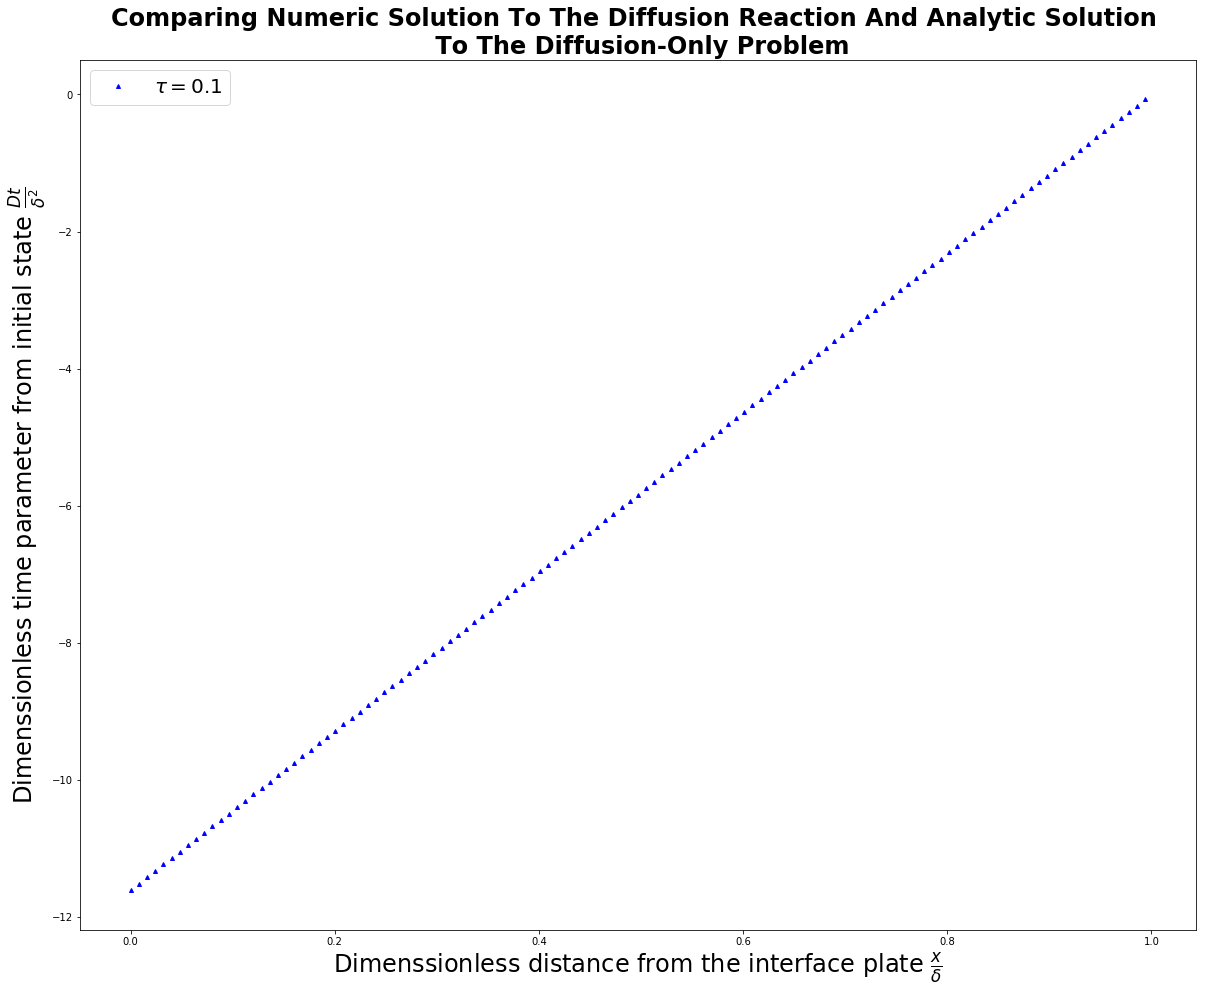

In [71]:
import matplotlib.pyplot as plt
import analyticDiffusionLangmuirBC

Cm = analyticDiffusionLangmuirBC.C_an
mw = 4
fs = 24
xi2 = remove_points(xi) # this is done to avoid cluttering of numeric points over the analytic solution
fig = plt.figure(figsize=(20,16))
t = 0.1
C1, C2, Psi = Model(t)
plt.title('Comparing Numeric Solution To The Diffusion Reaction And Analytic Solution \n To The Diffusion-Only Problem', fontsize=fs, fontweight='bold')
plt.plot(xi2, remove_points(Psi), 'b^', markersize=mw, label=r'$\tau='+str(t)+'$')
plt.xlabel(r'Dimenssionless distance from the interface plate $\frac{x}{\delta}$', fontsize=fs)
plt.ylabel(r'Dimenssionless time parameter from initial state $\frac{Dt}{\delta^2}$', fontsize=fs)
#plt.text(0.9, 40, r'Reaction Rate', fontsize = 14, color = 'black')
#plt.text(0.9, 37, r'$r = - 1.5 \times 10 \frac{A}{m^2}$', fontsize = 14, color = 'black')
plt.legend(fontsize = fs-4)
plt.savefig('../../../img/concentration-diffusion-reaction-comparison.eps', format='eps', dpi=1000, fontsize=16, fontweight='bold')
plt.show()

## Comparison with analytic solution

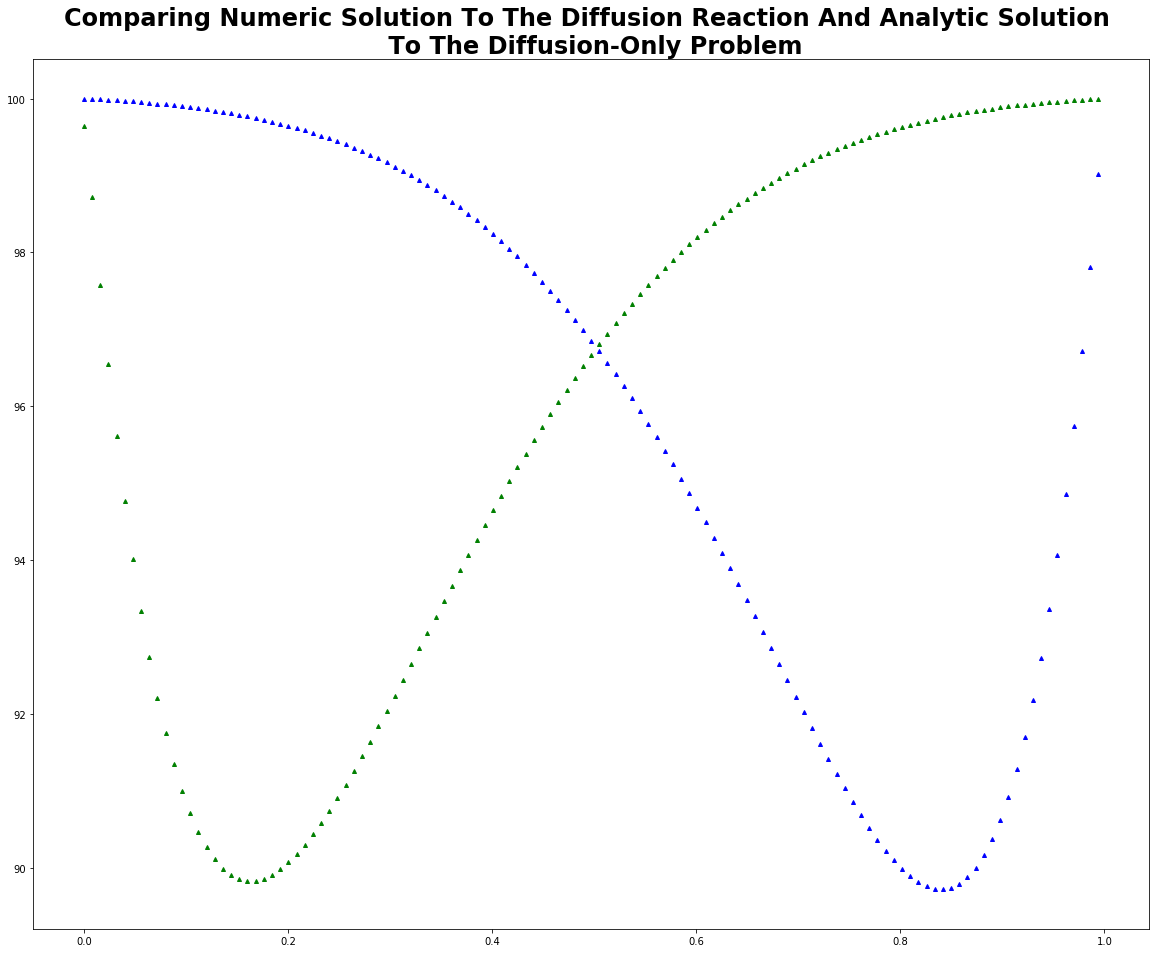

In [72]:
fig = plt.figure(figsize=(20,16))
plt.title('Comparing Numeric Solution To The Diffusion Reaction And Analytic Solution \n To The Diffusion-Only Problem', fontsize=fs, fontweight='bold')
plt.plot(xi2, remove_points(C2), 'g^', markersize=mw, label=r'$\tau='+str(t)+'$')
plt.plot(xi2, remove_points(C1), 'b^', markersize=mw, label=r'$\tau='+str(t)+'$')
plt.show()